In [1]:
import os
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import glob
import missingno as msno
from scipy.stats import ttest_ind
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

### Cargue de datos

In [2]:
# cargar los datos en csv
data = pd.read_csv('dataset_3.csv',
                   sep=';', #Parámetro de separación de datos
                   encoding='utf-8' #Codificación de datos
                  )
data.drop(data.columns[0],axis=1,inplace=True)
print(data.shape)
#visualizar los primeros registros
data.head(5)

(5029969, 18)


,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS,is_slide,slide_FK
0,637085.126257,965898.966867,7.0,-1.972500,80.039055,8860.464,37.500000,2551.3591,7.0,12.0,0.209492,355.293000,255.0,5.959947,15.154297,8.0,False,0.0
1,637072.626257,965898.966867,7.0,1.644062,88.388350,8852.269,25.000000,2554.2786,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0,False,0.0
2,637110.126257,965911.466867,7.0,2.063750,72.886900,8867.471,63.737743,2547.0962,7.0,12.0,0.209140,63.449420,255.0,13.375040,12.150391,8.0,False,0.0
3,637097.626257,965911.466867,7.0,2.821250,80.039055,8859.246,51.538822,2549.3420,7.0,12.0,0.209140,48.567110,255.0,14.689607,13.618164,8.0,False,0.0
4,637085.126257,965911.466867,7.0,2.158594,88.388350,8851.033,39.528470,2551.5217,7.0,12.0,0.209492,40.382770,255.0,13.636049,15.251465,8.0,False,0.0


### Data Check

In [3]:
print(f"Hay datos duplicados? {data.duplicated().any()}")
print(f"Hay datos duplicados? \n{data.isna().any()}") 
data.shape

Hay datos duplicados? False
Hay datos duplicados? 
coord_y               False
coord_x               False
Cobertura             False
Curvatura             False
Distancia_Drenajes    False
Distancia_Fallas      False
Distancia_Vias        False
DTM                   False
Geologia              False
Geomorfologia         False
NDVI                  False
Orientaciones         False
Rugosidad             False
Slope                 False
TPI                   False
UGS                   False
is_slide              False
slide_FK              False
dtype: bool


(5029969, 18)

### Preprocesamiento
Se filtraran lo datos basados en algunas reglas de negocio y valores atipicos, siempre y cuando esto no disminuya el numero de puntos de derrumbes en el dataset.

In [4]:
# Filtrar outliers de Curvatura: menores a -10 y mayores a 10
print(f'Se filtran {data.Curvatura[(data.Curvatura<-10)|(data.Curvatura>10)].shape} registros')
data_1 = data.loc[(data.Curvatura>-10)&(data.Curvatura<10)]

Se filtran (2424,) registros


In [5]:
# Filtrar outliers de NDVI: mayor a 0.6
print(f'Se filtran {data_1.NDVI[data_1.NDVI>0.6].shape} registros')
data_1 = data_1.loc[(data_1.NDVI<0.6)]

Se filtran (862,) registros


In [6]:
# Filtrar outliers TPI: menor que -85 y mayor que 85
print(f'Se filtran {data_1.TPI[(data_1.TPI<-85)|(data_1.TPI>85)].shape} registros')
data_1 = data_1.loc[(data_1.TPI>-85)&(data_1.TPI<85)]

Se filtran (1201,) registros


In [7]:
# Filtrar cuerpos de agua residuales
print(f'Se filtran {data_1[(data_1.Geologia==1)|(data_1.Geomorfologia==1)].shape} registros')
data_1 = data_1.loc[(data_1.Geologia!=1)&(data_1.Geomorfologia!=1)]
data_1.shape

Se filtran (321, 18) registros


(5025159, 18)

### Ingenieria de Caracteristicas
Crearemos una variable con base en la cercania de los puntos a derrumbes historicos, de tal forma que todos los puntos en un "radio" de 25 metros al rededor de un derrumbe marquen "TRUE" para la variable "is_close2slide" 

In [8]:
data_1['is_close2slide'] = 0
n=1
for index, row in data_1[data_1.is_slide==True].iterrows():
    data_1.loc[(data_1.coord_x.between(row.coord_x-12.5*n,row.coord_x+12.5*n,inclusive='both')) &
               (data_1.coord_y.between(row.coord_y-12.5*n,row.coord_y+12.5*n,inclusive='both')) &
               (data_1.index != index),
               ['is_close2slide']] = 1

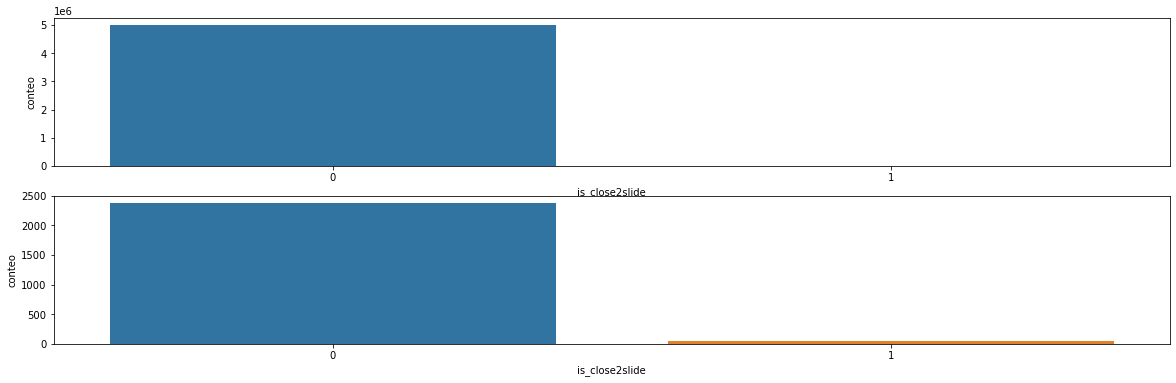

In [9]:
%matplotlib inline
# Podemos utilizar la tabla de frecuencias para realizar el gráfico
data_close2slide = data_1.groupby(['is_slide','is_close2slide']).size().reset_index(name="cnt")
# cambiamos el nombre de las columnas
data_close2slide.columns=['derrumbe','is_close2slide','conteo']
fig, ax = plt.subplots(2, 1,figsize=(20,6))
sns.barplot(x = 'is_close2slide', y = "conteo", data = data_close2slide[data_close2slide.derrumbe==0], ax=ax[0])
sns.barplot(x = 'is_close2slide', y = "conteo", data = data_close2slide[data_close2slide.derrumbe==1], ax=ax[1])
plt.show()

In [10]:
data_1.head()

,coord_y,coord_x,Cobertura,Curvatura,Distancia_Drenajes,Distancia_Fallas,Distancia_Vias,DTM,Geologia,Geomorfologia,NDVI,Orientaciones,Rugosidad,Slope,TPI,UGS,is_slide,slide_FK,is_close2slide
0,637085.126257,965898.966867,7.0,-1.972500,80.039055,8860.464,37.500000,2551.3591,7.0,12.0,0.209492,355.293000,255.0,5.959947,15.154297,8.0,False,0.0,0
1,637072.626257,965898.966867,7.0,1.644062,88.388350,8852.269,25.000000,2554.2786,7.0,12.0,0.209492,14.471906,255.0,6.341040,17.635742,8.0,False,0.0,0
2,637110.126257,965911.466867,7.0,2.063750,72.886900,8867.471,63.737743,2547.0962,7.0,12.0,0.209140,63.449420,255.0,13.375040,12.150391,8.0,False,0.0,0
3,637097.626257,965911.466867,7.0,2.821250,80.039055,8859.246,51.538822,2549.3420,7.0,12.0,0.209140,48.567110,255.0,14.689607,13.618164,8.0,False,0.0,0
4,637085.126257,965911.466867,7.0,2.158594,88.388350,8851.033,39.528470,2551.5217,7.0,12.0,0.209492,40.382770,255.0,13.636049,15.251465,8.0,False,0.0,0


## Anaisis de variables

### Prueba de hipotesis

In [11]:
var = 'TPI'
p_H0 = data_1[data_1['is_slide']== False][var]
p_H1 = data_1[data_1['is_slide']== True][var]
print(f'Promedio de el {var} para los no derrumbes es: {str(p_H0.mean())}')
print(f'Promedio de el {var} sistolica para los derrumbes es: {str(p_H1.mean())}')

Promedio de el TPI para los no derrumbes es: 0.4056426718656773
Promedio de el TPI sistolica para los derrumbes es: -1.8283206636382265


In [12]:
ttest,pval = ttest_ind(p_H0,p_H1)
print('Valor de t: '+str(ttest))
print('Valor p: '+ str(pval))

# Regla de decisión si el p valor es menor que la significancia escogida 
confianza=0.95
significancia=1-confianza
# Si se tiene menor valor se rechaza la hipótesis nula
if pval<significancia:
    print("Rechazar hipótesis nula")
else:
    print("No rechazar hipótesis nula")

Valor de t: 6.843583545330837
Valor p: 7.724503118427775e-12
Rechazar hipótesis nula


### Correlaciones

In [13]:
#Se descartan las variables categoricas y para las cuales no se pudo rechazar la hipotesis nula.
df_corr = data_1.drop(['coord_y','coord_x','Cobertura','Geologia','Geomorfologia',
                       'UGS','is_slide','slide_FK', 'Distancia_Drenajes'], 1)
corr = df_corr.corr()
corr

,Curvatura,Distancia_Fallas,Distancia_Vias,DTM,NDVI,Orientaciones,Rugosidad,Slope,TPI,is_close2slide
Curvatura,1.000000,-0.000521,-0.001176,0.045474,-0.004918,-0.000745,-0.003924,0.008363,0.497388,-0.003058
Distancia_Fallas,-0.000521,1.000000,0.096936,0.051104,-0.065479,-0.003306,-0.010848,0.007781,-0.003619,-0.015853
Distancia_Vias,-0.001176,0.096936,1.000000,-0.157041,-0.316796,0.035145,-0.106103,0.334652,0.000528,-0.012161
DTM,0.045474,0.051104,-0.157041,1.000000,-0.276925,-0.020699,0.011671,-0.065787,0.155366,0.015241
NDVI,-0.004918,-0.065479,-0.316796,-0.276925,1.000000,-0.078116,0.023429,-0.017821,-0.017476,0.007953
Orientaciones,-0.000745,-0.003306,0.035145,-0.020699,-0.078116,1.000000,0.493976,-0.020279,-0.005939,-0.008041
Rugosidad,-0.003924,-0.010848,-0.106103,0.011671,0.023429,0.493976,1.000000,-0.244026,-0.005984,-0.010575
Slope,0.008363,0.007781,0.334652,-0.065787,-0.017821,-0.020279,-0.244026,1.000000,0.033755,0.017730
TPI,0.497388,-0.003619,0.000528,0.155366,-0.017476,-0.005939,-0.005984,0.033755,1.000000,-0.008835
is_close2slide,-0.003058,-0.015853,-0.012161,0.015241,0.007953,-0.008041,-0.010575,0.017730,-0.008835,1.000000


<AxesSubplot:>

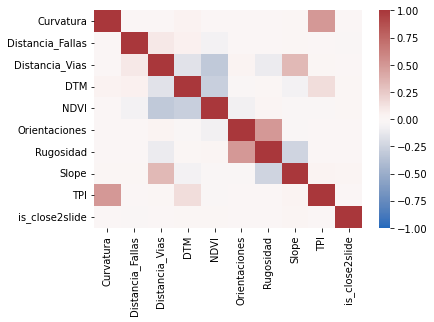

In [14]:
#Realizar el gráfico de correlación
sns.heatmap(corr,
            vmin=-1.00, vmax=1.00,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="vlag")

### Preparacion de Datasets de entrenamiento

In [15]:
# Se selecciona la variable objetivo, en este caso "TARGET".
Y = data_1.is_slide
# Del conjunto de datos se elimina la variable "TARGET".
X = data_1.drop(['coord_y','coord_x','Geologia','Geomorfologia','UGS','slide_FK','Distancia_Drenajes','is_slide'], 1)

In [16]:
X = pd.get_dummies(X, columns=['Cobertura'], drop_first=True, prefix=['Cob'])

In [18]:
scaler = preprocessing.StandardScaler()
X.iloc[:, :9] = scaler.fit_transform(X.iloc[:, :9])
pd.DataFrame(X)

,Curvatura,Distancia_Fallas,Distancia_Vias,DTM,NDVI,Orientaciones,Rugosidad,Slope,TPI,is_close2slide,...,Cob_11.0,Cob_12.0,Cob_13.0,Cob_14.0,Cob_15.0,Cob_16.0,Cob_17.0,Cob_18.0,Cob_19.0,Cob_23.0
0,-1.856069,3.517984,-0.576946,-1.381002,0.778075,1.628758,1.845775,-1.319342,0.915332,0,...,0,0,0,0,0,0,0,0,0,0
1,1.540985,3.513614,-0.580745,-1.372281,0.778075,-1.666146,1.845775,-1.280677,1.069324,0,...,0,0,0,0,0,0,0,0,0,0
2,1.935199,3.521720,-0.568971,-1.393736,0.774893,-1.192654,1.845775,-0.567021,0.728917,0,...,0,0,0,0,0,0,0,0,0,0
3,2.646722,3.517334,-0.572679,-1.387028,0.774893,-1.336529,1.845775,-0.433647,0.820003,0,...,0,0,0,0,0,0,0,0,0,0
4,2.024286,3.512955,-0.576329,-1.380516,0.778075,-1.415652,1.845775,-0.540539,0.921362,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5029964,0.380503,1.904209,0.676680,1.258653,-0.529354,-0.121840,-0.257801,-1.070470,0.233411,0,...,0,0,0,0,1,0,0,0,0,0
5029965,0.297287,1.899443,0.678259,1.252678,-0.529354,-0.035267,1.845775,-1.127833,0.144173,0,...,0,0,0,0,1,0,0,0,0,0
5029966,-0.389727,1.894683,0.679848,1.246704,-0.529354,-0.035666,1.845775,-1.267027,0.056345,0,...,0,0,0,0,1,0,0,0,0,0
5029967,0.318421,1.908868,0.680138,1.257941,-0.529354,-0.093468,1.845775,-1.280619,0.170248,0,...,0,0,0,0,1,0,0,0,0,0


In [24]:
# Se realiza la división entrenamiento - test. Se deja 20% de los datos para el test.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, stratify=Y, random_state = 22)

### Seleccion de variables

In [25]:
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

         Current function value: 0.004007
         Iterations: 35


C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517581
Method:                           MLE   Df Model:                           29
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04325
Time:                        19:31:15   Log-Likelihood:                -14095.
converged:                      False   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                6.444e-250
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.4640      0.192    -38.919      0.000      -7.840      -7.088
Curvatura            0.0297      0.025      1.198      0.231      -0.019       0.078
Distancia_Fallas    -0.2094      0.030     -7.021      0.000      -0.268      -0.151
Distancia_Vias      -0.4216      0.044     -9.586      0.000      -0.508      -0.335
DTM                  0.1627      0.032      5.086      0.000       0.100       0.225
NDVI                 0.1546      0.024      6.413      0.000       0.107       0.202
Orientaciones       -0.0435      0.028     -1.535      0.125      -0.099       0.012
Rugosidad           -0.0798      0.026     -3.110      0.002      -0.130      -0.030
Slope                0.2603      0.025     10.244      0.000       0.210       0.310
TPI                 -0.1943      0.027     -7.266      0.000      -0.247      -0.142
is_close2slide       0.8178      0.168      4.863      0.000       0.488       1.147
Cob_2.0             -0.5513      0.354     -1.555      0.120      -1.246       0.143
Cob_3.0              0.3235      0.422      0.766      0.444      -0.504       1.151
Cob_4.0              1.4466      0.321      4.508      0.000       0.818       2.076
Cob_5.0            -15.7376   1.04e+04     -0.002      0.999   -2.05e+04    2.04e+04
Cob_6.0             -0.6744      0.271     -2.491      0.013      -1.205      -0.144
Cob_7.0             -0.3166      0.371     -0.854      0.393      -1.043       0.410
Cob_8.0             -0.2880      0.312     -0.924      0.356      -0.899       0.323
Cob_9.0             -0.6709      0.223     -3.006      0.003      -1.108      -0.233
Cob_10.0            -0.4798      0.259     -1.853      0.064      -0.987       0.028
Cob_11.0            -0.9050      0.207     -4.363      0.000      -1.312      -0.498
Cob_12.0            -0.4096      0.207     -1.977      0.048      -0.816      -0.003
Cob_13.0             0.4788      0.323      1.480      0.139      -0.155       1.113
Cob_14.0            -0.2765      0.199     -1.391      0.164      -0.666       0.113
Cob_15.0            -0.4508      0.202     -2.234      0.025      -0.846      -0.055
Cob_16.0            -0.3145      0.253     -1.242      0.214      -0.811       0.182
Cob_17.0             2.6149      0.262      9.965      0.000       2.101       3.129
Cob_18.0             0.4517      0.238      1.897      0.058      -0.015       0.918
Cob_19.0            -0.1276      0.466     -0.274      0.784      -1.040       0.785
Cob_23.0           -16.4248   6138.075     -0.003      0.998    -1.2e+04     1.2e+04
====================================================================================
"""

In [26]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_5.0'], axis=1)
X_test = X_test.drop(['Cob_5.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

         Current function value: 0.004007
         Iterations: 35


C:\Users\gvargasj\.conda\envs\MINE-DS\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517582
Method:                           MLE   Df Model:                           28
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04324
Time:                        19:33:25   Log-Likelihood:                -14095.
converged:                      False   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.006e-250
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.4662      0.192    -38.931      0.000      -7.842      -7.090
Curvatura            0.0297      0.025      1.198      0.231      -0.019       0.078
Distancia_Fallas    -0.2094      0.030     -7.020      0.000      -0.268      -0.151
Distancia_Vias      -0.4216      0.044     -9.586      0.000      -0.508      -0.335
DTM                  0.1627      0.032      5.085      0.000       0.100       0.225
NDVI                 0.1546      0.024      6.414      0.000       0.107       0.202
Orientaciones       -0.0435      0.028     -1.536      0.125      -0.099       0.012
Rugosidad           -0.0798      0.026     -3.110      0.002      -0.130      -0.029
Slope                0.2603      0.025     10.245      0.000       0.211       0.310
TPI                 -0.1943      0.027     -7.266      0.000      -0.247      -0.142
is_close2slide       0.8178      0.168      4.863      0.000       0.488       1.147
Cob_2.0             -0.5491      0.354     -1.549      0.121      -1.244       0.146
Cob_3.0              0.3256      0.422      0.771      0.441      -0.502       1.153
Cob_4.0              1.4487      0.321      4.514      0.000       0.820       2.078
Cob_6.0             -0.6722      0.271     -2.483      0.013      -1.203      -0.142
Cob_7.0             -0.3144      0.371     -0.848      0.396      -1.041       0.412
Cob_8.0             -0.2859      0.312     -0.917      0.359      -0.897       0.325
Cob_9.0             -0.6687      0.223     -2.996      0.003      -1.106      -0.231
Cob_10.0            -0.4777      0.259     -1.845      0.065      -0.985       0.030
Cob_11.0            -0.9028      0.207     -4.352      0.000      -1.309      -0.496
Cob_12.0            -0.4075      0.207     -1.966      0.049      -0.814      -0.001
Cob_13.0             0.4809      0.323      1.487      0.137      -0.153       1.115
Cob_14.0            -0.2743      0.199     -1.380      0.168      -0.664       0.115
Cob_15.0            -0.4486      0.202     -2.223      0.026      -0.844      -0.053
Cob_16.0            -0.3124      0.253     -1.234      0.217      -0.809       0.184
Cob_17.0             2.6173      0.262      9.975      0.000       2.103       3.132
Cob_18.0             0.4539      0.238      1.907      0.057      -0.013       0.920
Cob_19.0            -0.1254      0.466     -0.269      0.788      -1.038       0.787
Cob_23.0           -16.4489   6219.022     -0.003      0.998   -1.22e+04    1.22e+04
====================================================================================
"""

In [27]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_23.0'], axis=1)
X_test = X_test.drop(['Cob_23.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517583
Method:                           MLE   Df Model:                           27
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04322
Time:                        19:34:32   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                2.058e-251
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.4785      0.192    -38.995      0.000      -7.854      -7.103
Curvatura            0.0298      0.025      1.199      0.231      -0.019       0.078
Distancia_Fallas    -0.2095      0.030     -7.023      0.000      -0.268      -0.151
Distancia_Vias      -0.4216      0.044     -9.585      0.000      -0.508      -0.335
DTM                  0.1626      0.032      5.084      0.000       0.100       0.225
NDVI                 0.1547      0.024      6.418      0.000       0.107       0.202
Orientaciones       -0.0433      0.028     -1.528      0.127      -0.099       0.012
Rugosidad           -0.0799      0.026     -3.114      0.002      -0.130      -0.030
Slope                0.2603      0.025     10.243      0.000       0.210       0.310
TPI                 -0.1943      0.027     -7.266      0.000      -0.247      -0.142
is_close2slide       0.8179      0.168      4.864      0.000       0.488       1.148
Cob_2.0             -0.5368      0.354     -1.515      0.130      -1.231       0.158
Cob_3.0              0.3379      0.422      0.800      0.424      -0.490       1.166
Cob_4.0              1.4609      0.321      4.552      0.000       0.832       2.090
Cob_6.0             -0.6600      0.271     -2.438      0.015      -1.191      -0.129
Cob_7.0             -0.3023      0.371     -0.815      0.415      -1.029       0.424
Cob_8.0             -0.2736      0.312     -0.877      0.380      -0.885       0.338
Cob_9.0             -0.6564      0.223     -2.941      0.003      -1.094      -0.219
Cob_10.0            -0.4654      0.259     -1.797      0.072      -0.973       0.042
Cob_11.0            -0.8905      0.207     -4.293      0.000      -1.297      -0.484
Cob_12.0            -0.3952      0.207     -1.907      0.057      -0.801       0.011
Cob_13.0             0.4930      0.323      1.524      0.127      -0.141       1.127
Cob_14.0            -0.2620      0.199     -1.318      0.188      -0.652       0.128
Cob_15.0            -0.4362      0.202     -2.162      0.031      -0.832      -0.041
Cob_16.0            -0.3003      0.253     -1.186      0.236      -0.797       0.196
Cob_17.0             2.6297      0.262     10.023      0.000       2.115       3.144
Cob_18.0             0.4663      0.238      1.959      0.050      -0.000       0.933
Cob_19.0            -0.1129      0.466     -0.243      0.808      -1.026       0.800
====================================================================================
"""

In [28]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_19.0'], axis=1)
X_test = X_test.drop(['Cob_19.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517584
Method:                           MLE   Df Model:                           26
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04322
Time:                        19:35:59   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                2.998e-252
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.4997      0.172    -43.547      0.000      -7.837      -7.162
Curvatura            0.0297      0.025      1.197      0.231      -0.019       0.078
Distancia_Fallas    -0.2091      0.030     -7.021      0.000      -0.268      -0.151
Distancia_Vias      -0.4218      0.044     -9.596      0.000      -0.508      -0.336
DTM                  0.1606      0.031      5.203      0.000       0.100       0.221
NDVI                 0.1543      0.024      6.414      0.000       0.107       0.201
Orientaciones       -0.0433      0.028     -1.529      0.126      -0.099       0.012
Rugosidad           -0.0798      0.026     -3.110      0.002      -0.130      -0.029
Slope                0.2598      0.025     10.252      0.000       0.210       0.310
TPI                 -0.1941      0.027     -7.262      0.000      -0.246      -0.142
is_close2slide       0.8179      0.168      4.864      0.000       0.488       1.147
Cob_2.0             -0.5176      0.346     -1.495      0.135      -1.196       0.161
Cob_3.0              0.3581      0.415      0.864      0.388      -0.455       1.171
Cob_4.0              1.4802      0.312      4.748      0.000       0.869       2.091
Cob_6.0             -0.6397      0.258     -2.475      0.013      -1.146      -0.133
Cob_7.0             -0.2821      0.362     -0.779      0.436      -0.992       0.427
Cob_8.0             -0.2513      0.299     -0.841      0.400      -0.837       0.334
Cob_9.0             -0.6354      0.207     -3.070      0.002      -1.041      -0.230
Cob_10.0            -0.4446      0.245     -1.811      0.070      -0.926       0.037
Cob_11.0            -0.8696      0.190     -4.571      0.000      -1.243      -0.497
Cob_12.0            -0.3741      0.190     -1.974      0.048      -0.746      -0.003
Cob_13.0             0.5118      0.315      1.625      0.104      -0.105       1.129
Cob_14.0            -0.2398      0.178     -1.347      0.178      -0.589       0.109
Cob_15.0            -0.4144      0.182     -2.277      0.023      -0.771      -0.058
Cob_16.0            -0.2809      0.241     -1.164      0.245      -0.754       0.192
Cob_17.0             2.6579      0.236     11.254      0.000       2.195       3.121
Cob_18.0             0.4911      0.216      2.271      0.023       0.067       0.915
====================================================================================
"""

In [29]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_7.0'], axis=1)
X_test = X_test.drop(['Cob_7.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517585
Method:                           MLE   Df Model:                           25
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04319
Time:                        19:37:13   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                5.682e-253
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.5681      0.153    -49.400      0.000      -7.868      -7.268
Curvatura            0.0297      0.025      1.196      0.232      -0.019       0.078
Distancia_Fallas    -0.2089      0.030     -7.015      0.000      -0.267      -0.151
Distancia_Vias      -0.4226      0.044     -9.610      0.000      -0.509      -0.336
DTM                  0.1611      0.031      5.209      0.000       0.100       0.222
NDVI                 0.1521      0.024      6.356      0.000       0.105       0.199
Orientaciones       -0.0437      0.028     -1.543      0.123      -0.099       0.012
Rugosidad           -0.0799      0.026     -3.115      0.002      -0.130      -0.030
Slope                0.2589      0.025     10.226      0.000       0.209       0.308
TPI                 -0.1940      0.027     -7.259      0.000      -0.246      -0.142
is_close2slide       0.8182      0.168      4.865      0.000       0.489       1.148
Cob_2.0             -0.4489      0.337     -1.332      0.183      -1.110       0.212
Cob_3.0              0.4279      0.407      1.052      0.293      -0.369       1.225
Cob_4.0              1.5513      0.301      5.160      0.000       0.962       2.141
Cob_6.0             -0.5679      0.245     -2.322      0.020      -1.047      -0.089
Cob_8.0             -0.1797      0.287     -0.626      0.531      -0.742       0.383
Cob_9.0             -0.5663      0.191     -2.965      0.003      -0.941      -0.192
Cob_10.0            -0.3744      0.232     -1.616      0.106      -0.828       0.080
Cob_11.0            -0.8009      0.173     -4.628      0.000      -1.140      -0.462
Cob_12.0            -0.3044      0.172     -1.774      0.076      -0.641       0.032
Cob_13.0             0.5851      0.303      1.931      0.053      -0.009       1.179
Cob_14.0            -0.1712      0.160     -1.073      0.283      -0.484       0.142
Cob_15.0            -0.3458      0.164     -2.108      0.035      -0.667      -0.024
Cob_16.0            -0.2075      0.226     -0.920      0.358      -0.650       0.235
Cob_17.0             2.7240      0.224     12.159      0.000       2.285       3.163
Cob_18.0             0.5588      0.202      2.769      0.006       0.163       0.954
====================================================================================
"""

In [30]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_8.0'], axis=1)
X_test = X_test.drop(['Cob_8.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517586
Method:                           MLE   Df Model:                           24
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04318
Time:                        19:38:44   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                9.402e-254
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.6205      0.132    -57.927      0.000      -7.878      -7.363
Curvatura            0.0296      0.025      1.194      0.233      -0.019       0.078
Distancia_Fallas    -0.2089      0.030     -7.019      0.000      -0.267      -0.151
Distancia_Vias      -0.4228      0.044     -9.616      0.000      -0.509      -0.337
DTM                  0.1595      0.031      5.180      0.000       0.099       0.220
NDVI                 0.1513      0.024      6.327      0.000       0.104       0.198
Orientaciones       -0.0435      0.028     -1.536      0.125      -0.099       0.012
Rugosidad           -0.0799      0.026     -3.116      0.002      -0.130      -0.030
Slope                0.2576      0.025     10.206      0.000       0.208       0.307
TPI                 -0.1937      0.027     -7.252      0.000      -0.246      -0.141
is_close2slide       0.8182      0.168      4.866      0.000       0.489       1.148
Cob_2.0             -0.3987      0.329     -1.213      0.225      -1.043       0.245
Cob_3.0              0.4796      0.399      1.201      0.230      -0.303       1.262
Cob_4.0              1.6028      0.291      5.515      0.000       1.033       2.172
Cob_6.0             -0.5152      0.231     -2.226      0.026      -0.969      -0.062
Cob_9.0             -0.5142      0.174     -2.949      0.003      -0.856      -0.172
Cob_10.0            -0.3222      0.218     -1.478      0.139      -0.749       0.105
Cob_11.0            -0.7489      0.155     -4.846      0.000      -1.052      -0.446
Cob_12.0            -0.2518      0.152     -1.653      0.098      -0.550       0.047
Cob_13.0             0.6370      0.293      2.175      0.030       0.063       1.211
Cob_14.0            -0.1177      0.138     -0.854      0.393      -0.388       0.152
Cob_15.0            -0.2927      0.143     -2.042      0.041      -0.574      -0.012
Cob_16.0            -0.1554      0.212     -0.734      0.463      -0.570       0.259
Cob_17.0             2.7824      0.206     13.530      0.000       2.379       3.185
Cob_18.0             0.6143      0.184      3.346      0.001       0.254       0.974
====================================================================================
"""

In [31]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_16.0'], axis=1)
X_test = X_test.drop(['Cob_16.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517587
Method:                           MLE   Df Model:                           23
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04316
Time:                        19:39:57   Log-Likelihood:                -14096.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.634e-254
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.6778      0.109    -70.629      0.000      -7.891      -7.465
Curvatura            0.0296      0.025      1.194      0.232      -0.019       0.078
Distancia_Fallas    -0.2101      0.030     -7.069      0.000      -0.268      -0.152
Distancia_Vias      -0.4228      0.044     -9.609      0.000      -0.509      -0.337
DTM                  0.1620      0.031      5.283      0.000       0.102       0.222
NDVI                 0.1501      0.024      6.287      0.000       0.103       0.197
Orientaciones       -0.0444      0.028     -1.568      0.117      -0.100       0.011
Rugosidad           -0.0800      0.026     -3.117      0.002      -0.130      -0.030
Slope                0.2571      0.025     10.187      0.000       0.208       0.307
TPI                 -0.1924      0.027     -7.219      0.000      -0.245      -0.140
is_close2slide       0.8190      0.168      4.870      0.000       0.489       1.149
Cob_2.0             -0.3398      0.320     -1.063      0.288      -0.966       0.287
Cob_3.0              0.5389      0.392      1.375      0.169      -0.229       1.307
Cob_4.0              1.6639      0.279      5.953      0.000       1.116       2.212
Cob_6.0             -0.4546      0.218     -2.090      0.037      -0.881      -0.028
Cob_9.0             -0.4565      0.158     -2.897      0.004      -0.765      -0.148
Cob_10.0            -0.2633      0.204     -1.289      0.197      -0.664       0.137
Cob_11.0            -0.6909      0.135     -5.116      0.000      -0.956      -0.426
Cob_12.0            -0.1935      0.132     -1.462      0.144      -0.453       0.066
Cob_13.0             0.7004      0.281      2.494      0.013       0.150       1.251
Cob_14.0            -0.0612      0.117     -0.523      0.601      -0.291       0.168
Cob_15.0            -0.2357      0.123     -1.916      0.055      -0.477       0.005
Cob_17.0             2.8298      0.197     14.367      0.000       2.444       3.216
Cob_18.0             0.6671      0.171      3.905      0.000       0.332       1.002
====================================================================================
"""

In [32]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_14.0'], axis=1)
X_test = X_test.drop(['Cob_14.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004007
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517588
Method:                           MLE   Df Model:                           22
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04315
Time:                        19:41:12   Log-Likelihood:                -14097.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                2.425e-255
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7310      0.039   -197.064      0.000      -7.808      -7.654
Curvatura            0.0296      0.025      1.193      0.233      -0.019       0.078
Distancia_Fallas    -0.2100      0.030     -7.066      0.000      -0.268      -0.152
Distancia_Vias      -0.4260      0.044     -9.770      0.000      -0.511      -0.341
DTM                  0.1582      0.030      5.292      0.000       0.100       0.217
NDVI                 0.1522      0.024      6.475      0.000       0.106       0.198
Orientaciones       -0.0450      0.028     -1.592      0.111      -0.100       0.010
Rugosidad           -0.0797      0.026     -3.106      0.002      -0.130      -0.029
Slope                0.2563      0.025     10.171      0.000       0.207       0.306
TPI                 -0.1928      0.027     -7.237      0.000      -0.245      -0.141
is_close2slide       0.8190      0.168      4.870      0.000       0.489       1.149
Cob_2.0             -0.2930      0.307     -0.954      0.340      -0.895       0.309
Cob_3.0              0.5863      0.381      1.538      0.124      -0.161       1.334
Cob_4.0              1.7087      0.266      6.417      0.000       1.187       2.231
Cob_6.0             -0.4088      0.199     -2.050      0.040      -0.800      -0.018
Cob_9.0             -0.4073      0.127     -3.213      0.001      -0.656      -0.159
Cob_10.0            -0.2158      0.183     -1.178      0.239      -0.575       0.143
Cob_11.0            -0.6410      0.096     -6.677      0.000      -0.829      -0.453
Cob_12.0            -0.1434      0.092     -1.561      0.118      -0.323       0.037
Cob_13.0             0.7436      0.269      2.767      0.006       0.217       1.270
Cob_15.0            -0.1825      0.070     -2.623      0.009      -0.319      -0.046
Cob_17.0             2.8959      0.151     19.139      0.000       2.599       3.192
Cob_18.0             0.7250      0.130      5.567      0.000       0.470       0.980
====================================================================================
"""

In [33]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_2.0'], axis=1)
X_test = X_test.drop(['Cob_2.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004008
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517589
Method:                           MLE   Df Model:                           21
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04312
Time:                        19:42:20   Log-Likelihood:                -14097.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                5.032e-256
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7371      0.039   -199.349      0.000      -7.813      -7.661
Curvatura            0.0297      0.025      1.197      0.231      -0.019       0.078
Distancia_Fallas    -0.2098      0.030     -7.057      0.000      -0.268      -0.152
Distancia_Vias      -0.4233      0.043     -9.734      0.000      -0.508      -0.338
DTM                  0.1616      0.030      5.436      0.000       0.103       0.220
NDVI                 0.1528      0.024      6.499      0.000       0.107       0.199
Orientaciones       -0.0451      0.028     -1.595      0.111      -0.100       0.010
Rugosidad           -0.0798      0.026     -3.112      0.002      -0.130      -0.030
Slope                0.2584      0.025     10.292      0.000       0.209       0.308
TPI                 -0.1936      0.027     -7.266      0.000      -0.246      -0.141
is_close2slide       0.8187      0.168      4.869      0.000       0.489       1.148
Cob_3.0              0.5958      0.381      1.563      0.118      -0.151       1.343
Cob_4.0              1.7191      0.266      6.461      0.000       1.198       2.241
Cob_6.0             -0.4005      0.199     -2.010      0.044      -0.791      -0.010
Cob_9.0             -0.3987      0.126     -3.152      0.002      -0.647      -0.151
Cob_10.0            -0.2071      0.183     -1.132      0.258      -0.566       0.151
Cob_11.0            -0.6327      0.096     -6.614      0.000      -0.820      -0.445
Cob_12.0            -0.1362      0.092     -1.487      0.137      -0.316       0.043
Cob_13.0             0.7539      0.269      2.808      0.005       0.228       1.280
Cob_15.0            -0.1771      0.069     -2.553      0.011      -0.313      -0.041
Cob_17.0             2.8909      0.151     19.111      0.000       2.594       3.187
Cob_18.0             0.7260      0.130      5.572      0.000       0.471       0.981
====================================================================================
"""

In [34]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_10.0'], axis=1)
X_test = X_test.drop(['Cob_10.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004008
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517590
Method:                           MLE   Df Model:                           20
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04307
Time:                        19:43:20   Log-Likelihood:                -14098.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.219e-256
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7466      0.038   -203.609      0.000      -7.821      -7.672
Curvatura            0.0297      0.025      1.196      0.232      -0.019       0.078
Distancia_Fallas    -0.2102      0.030     -7.066      0.000      -0.268      -0.152
Distancia_Vias      -0.4196      0.043     -9.689      0.000      -0.504      -0.335
DTM                  0.1638      0.030      5.517      0.000       0.106       0.222
NDVI                 0.1507      0.023      6.430      0.000       0.105       0.197
Orientaciones       -0.0446      0.028     -1.577      0.115      -0.100       0.011
Rugosidad           -0.0794      0.026     -3.098      0.002      -0.130      -0.029
Slope                0.2608      0.025     10.427      0.000       0.212       0.310
TPI                 -0.1940      0.027     -7.277      0.000      -0.246      -0.142
is_close2slide       0.8188      0.168      4.868      0.000       0.489       1.148
Cob_3.0              0.6098      0.381      1.600      0.110      -0.137       1.357
Cob_4.0              1.7337      0.266      6.522      0.000       1.213       2.255
Cob_6.0             -0.3856      0.199     -1.938      0.053      -0.775       0.004
Cob_9.0             -0.3846      0.126     -3.054      0.002      -0.631      -0.138
Cob_11.0            -0.6198      0.095     -6.520      0.000      -0.806      -0.434
Cob_12.0            -0.1243      0.091     -1.365      0.172      -0.303       0.054
Cob_13.0             0.7684      0.268      2.864      0.004       0.243       1.294
Cob_15.0            -0.1675      0.069     -2.430      0.015      -0.303      -0.032
Cob_17.0             2.8907      0.151     19.098      0.000       2.594       3.187
Cob_18.0             0.7334      0.130      5.634      0.000       0.478       0.989
====================================================================================
"""

In [35]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Curvatura'], axis=1)
X_test = X_test.drop(['Curvatura'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004008
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517591
Method:                           MLE   Df Model:                           19
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04302
Time:                        19:44:25   Log-Likelihood:                -14099.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                2.979e-257
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7460      0.038   -203.651      0.000      -7.821      -7.671
Distancia_Fallas    -0.2100      0.030     -7.060      0.000      -0.268      -0.152
Distancia_Vias      -0.4197      0.043     -9.693      0.000      -0.505      -0.335
DTM                  0.1627      0.030      5.482      0.000       0.105       0.221
NDVI                 0.1506      0.023      6.423      0.000       0.105       0.197
Orientaciones       -0.0443      0.028     -1.567      0.117      -0.100       0.011
Rugosidad           -0.0792      0.026     -3.087      0.002      -0.129      -0.029
Slope                0.2609      0.025     10.432      0.000       0.212       0.310
TPI                 -0.1789      0.024     -7.605      0.000      -0.225      -0.133
is_close2slide       0.8202      0.168      4.878      0.000       0.491       1.150
Cob_3.0              0.6108      0.381      1.603      0.109      -0.136       1.358
Cob_4.0              1.7319      0.266      6.515      0.000       1.211       2.253
Cob_6.0             -0.3866      0.199     -1.944      0.052      -0.776       0.003
Cob_9.0             -0.3848      0.126     -3.056      0.002      -0.632      -0.138
Cob_11.0            -0.6202      0.095     -6.524      0.000      -0.807      -0.434
Cob_12.0            -0.1249      0.091     -1.372      0.170      -0.303       0.054
Cob_13.0             0.7649      0.268      2.851      0.004       0.239       1.291
Cob_15.0            -0.1682      0.069     -2.439      0.015      -0.303      -0.033
Cob_17.0             2.8919      0.151     19.112      0.000       2.595       3.189
Cob_18.0             0.7328      0.130      5.629      0.000       0.478       0.988
====================================================================================
"""

In [36]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_12.0'], axis=1)
X_test = X_test.drop(['Cob_12.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004008
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517592
Method:                           MLE   Df Model:                           18
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04296
Time:                        19:45:24   Log-Likelihood:                -14099.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                9.086e-258
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7659      0.035   -219.141      0.000      -7.835      -7.696
Distancia_Fallas    -0.2095      0.030     -7.047      0.000      -0.268      -0.151
Distancia_Vias      -0.4137      0.043     -9.614      0.000      -0.498      -0.329
DTM                  0.1664      0.030      5.635      0.000       0.109       0.224
NDVI                 0.1493      0.023      6.366      0.000       0.103       0.195
Orientaciones       -0.0450      0.028     -1.592      0.111      -0.100       0.010
Rugosidad           -0.0798      0.026     -3.112      0.002      -0.130      -0.030
Slope                0.2622      0.025     10.491      0.000       0.213       0.311
TPI                 -0.1800      0.024     -7.650      0.000      -0.226      -0.134
is_close2slide       0.8199      0.168      4.877      0.000       0.490       1.149
Cob_3.0              0.6373      0.381      1.674      0.094      -0.109       1.383
Cob_4.0              1.7601      0.265      6.640      0.000       1.241       2.280
Cob_6.0             -0.3602      0.198     -1.819      0.069      -0.748       0.028
Cob_9.0             -0.3599      0.125     -2.886      0.004      -0.604      -0.115
Cob_11.0            -0.5959      0.094     -6.371      0.000      -0.779      -0.413
Cob_13.0             0.7956      0.267      2.975      0.003       0.271       1.320
Cob_15.0            -0.1478      0.067     -2.190      0.028      -0.280      -0.016
Cob_17.0             2.9002      0.151     19.181      0.000       2.604       3.197
Cob_18.0             0.7480      0.130      5.763      0.000       0.494       1.002
====================================================================================
"""

In [37]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Orientaciones'], axis=1)
X_test = X_test.drop(['Orientaciones'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004009
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517593
Method:                           MLE   Df Model:                           17
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04287
Time:                        19:46:15   Log-Likelihood:                -14101.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                3.579e-258
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7639      0.035   -219.402      0.000      -7.833      -7.695
Distancia_Fallas    -0.2104      0.030     -7.072      0.000      -0.269      -0.152
Distancia_Vias      -0.4142      0.043     -9.644      0.000      -0.498      -0.330
DTM                  0.1693      0.030      5.738      0.000       0.111       0.227
NDVI                 0.1541      0.023      6.624      0.000       0.109       0.200
Rugosidad           -0.0991      0.023     -4.390      0.000      -0.143      -0.055
Slope                0.2587      0.025     10.379      0.000       0.210       0.308
TPI                 -0.1795      0.024     -7.634      0.000      -0.226      -0.133
is_close2slide       0.8229      0.168      4.894      0.000       0.493       1.152
Cob_3.0              0.6409      0.381      1.684      0.092      -0.105       1.387
Cob_4.0              1.7682      0.265      6.672      0.000       1.249       2.288
Cob_6.0             -0.3521      0.198     -1.778      0.075      -0.740       0.036
Cob_9.0             -0.3623      0.125     -2.906      0.004      -0.607      -0.118
Cob_11.0            -0.5980      0.094     -6.395      0.000      -0.781      -0.415
Cob_13.0             0.7902      0.267      2.955      0.003       0.266       1.314
Cob_15.0            -0.1522      0.067     -2.258      0.024      -0.284      -0.020
Cob_17.0             2.8937      0.151     19.137      0.000       2.597       3.190
Cob_18.0             0.7517      0.130      5.795      0.000       0.497       1.006
====================================================================================
"""

In [38]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_3.0'], axis=1)
X_test = X_test.drop(['Cob_3.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004009
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517594
Method:                           MLE   Df Model:                           16
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04279
Time:                        19:47:13   Log-Likelihood:                -14102.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                1.252e-258
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7606      0.035   -219.920      0.000      -7.830      -7.691
Distancia_Fallas    -0.2108      0.030     -7.088      0.000      -0.269      -0.153
Distancia_Vias      -0.4164      0.043     -9.694      0.000      -0.501      -0.332
DTM                  0.1675      0.029      5.686      0.000       0.110       0.225
NDVI                 0.1539      0.023      6.617      0.000       0.108       0.199
Rugosidad           -0.0989      0.023     -4.383      0.000      -0.143      -0.055
Slope                0.2583      0.025     10.365      0.000       0.209       0.307
TPI                 -0.1795      0.024     -7.639      0.000      -0.226      -0.133
is_close2slide       0.8231      0.168      4.895      0.000       0.494       1.153
Cob_4.0              1.7612      0.265      6.647      0.000       1.242       2.281
Cob_6.0             -0.3576      0.198     -1.807      0.071      -0.746       0.030
Cob_9.0             -0.3672      0.125     -2.946      0.003      -0.611      -0.123
Cob_11.0            -0.6028      0.093     -6.452      0.000      -0.786      -0.420
Cob_13.0             0.7829      0.267      2.928      0.003       0.259       1.307
Cob_15.0            -0.1556      0.067     -2.310      0.021      -0.288      -0.024
Cob_17.0             2.8951      0.151     19.152      0.000       2.599       3.191
Cob_18.0             0.7509      0.130      5.789      0.000       0.497       1.005
====================================================================================
"""

In [40]:
# Ajustar el modelo para ver el reporte
X_train = X_train.drop(['Cob_6.0'], axis=1)
X_test = X_test.drop(['Cob_6.0'], axis=1)
#adding constant to X
X_train_with_constant = sm.add_constant(X_train)
X_test_with_constant = sm.add_constant(X_test)
# building the model and fitting the data
sm_model_all_predictors = sm.Logit(Y_train, X_train_with_constant).fit()
# printing the summary table
#print(sm_model_all_predictors.params)
sm_model_all_predictors.summary()

Optimization terminated successfully.
         Current function value: 0.004009
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               is_slide   No. Observations:              3517611
Model:                          Logit   Df Residuals:                  3517595
Method:                           MLE   Df Model:                           15
Date:                Thu, 11 Nov 2021   Pseudo R-squ.:                 0.04267
Time:                        19:48:34   Log-Likelihood:                -14104.
converged:                       True   LL-Null:                       -14732.
Covariance Type:            nonrobust   LLR p-value:                8.112e-259
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.7704      0.035   -222.046      0.000      -7.839      -7.702
Distancia_Fallas    -0.2110      0.030     -7.101      0.000      -0.269      -0.153
Distancia_Vias      -0.4123      0.043     -9.607      0.000      -0.496      -0.328
DTM                  0.1739      0.029      5.959      0.000       0.117       0.231
NDVI                 0.1505      0.023      6.476      0.000       0.105       0.196
Rugosidad           -0.0969      0.023     -4.299      0.000      -0.141      -0.053
Slope                0.2580      0.025     10.362      0.000       0.209       0.307
TPI                 -0.1801      0.023     -7.666      0.000      -0.226      -0.134
is_close2slide       0.8236      0.168      4.898      0.000       0.494       1.153
Cob_4.0              1.7854      0.265      6.745      0.000       1.267       2.304
Cob_9.0             -0.3523      0.124     -2.831      0.005      -0.596      -0.108
Cob_11.0            -0.5887      0.093     -6.317      0.000      -0.771      -0.406
Cob_13.0             0.8099      0.267      3.033      0.002       0.287       1.333
Cob_15.0            -0.1459      0.067     -2.170      0.030      -0.278      -0.014
Cob_17.0             2.8849      0.151     19.107      0.000       2.589       3.181
Cob_18.0             0.7531      0.130      5.807      0.000       0.499       1.007
====================================================================================
"""

In [44]:
scikit_default = LogisticRegression(random_state=0,class_weight={False: 1.03956194e-04, True: 2.14118336e-01}).fit(X_train, Y_train)
print(f"intecept: {scikit_default.intercept_} coeficients: {scikit_default.coef_}")
print(f"train accuracy: {scikit_default.score(X_train, Y_train)}")
print(f"test accuracy: {scikit_default.score(X_test, Y_test)}")

intecept: [-0.12103803] coeficients: [[-0.22514269 -0.43945556  0.17069504  0.17758601 -0.08288073  0.28782322
  -0.17032053  0.26256262  0.63233732 -0.30932964 -0.61168418  0.43277734
  -0.18353013  1.34462263  0.55671082]]
train accuracy: 0.6545794859067703
test accuracy: 0.6552905778124478


In [45]:
confusion_matrix(Y_test, scikit_default.predict(X_test))

array([[987460, 519357],
       [   309,    422]], dtype=int64)

In [46]:
422/731

0.5772913816689467

In [43]:
731 / (2 * np.bincount(Y_train)) #,class_weight={False: 6.07240547e-05, True: 1.25128205e-01}

array([1.03956194e-04, 2.14118336e-01])

In [114]:
pred_proba_df = pd.DataFrame(scikit_default.predict_proba(X_train))
pred_proba_df

,0,1
0,0.870549,0.129451
1,0.592921,0.407079
2,0.599028,0.400972
3,0.373797,0.626203
4,0.469257,0.530743
...,...,...
4020122,0.674487,0.325513
4020123,0.577329,0.422671
4020124,0.447255,0.552745
4020125,0.527263,0.472737


<AxesSubplot:xlabel='1', ylabel='Count'>

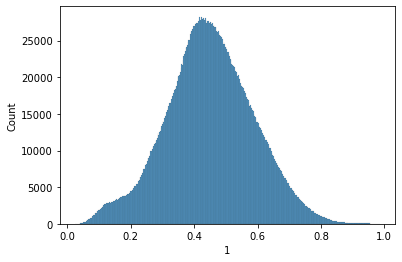

In [117]:
sns.histplot(x = 1, data = pred_proba_df)